In [1]:
import os
import cv2
import sys
import PIL
import pickle
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from matplotlib.gridspec import GridSpec
from sklearn.model_selection import ParameterGrid

In [2]:
sys.path.append("C:/Users/begas/Desktop/Project/Python/SmartFarm/5. SRC") # 다른 경로의 Class 불러올 때 사용
import model_tools             as mdl

C:\Users\begas\Anaconda3\lib\site-packages\dask\dataframe\utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
np.random.seed(1234)
tf.random.set_seed(1234)

### Setting

In [4]:
# -----------------------------------------------|
# ----- Step 1. Settings ------------------------
# -----------------------------------------------|
os.chdir("C:/Users/begas/Desktop/Project/Python/TuningMethods")
os.getcwd()

home_path  = os.getcwd()
data_path  = os.path.join(home_path,"1. DAT")
save_path  = os.path.join(home_path,"2. OUT")
model_path = os.path.join(home_path,"3. MODEL")

os.makedirs(data_path,exist_ok=True)
os.makedirs(save_path,exist_ok=True)
os.makedirs(model_path,exist_ok=True)

### Data Load

In [5]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [6]:
flower_list = [s for s in os.listdir(data_dir) if 'txt' not in s]

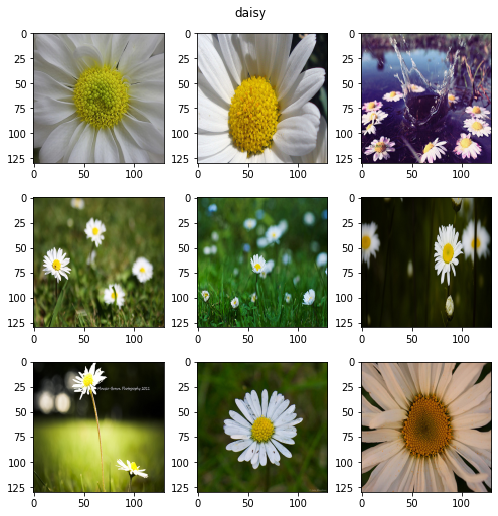

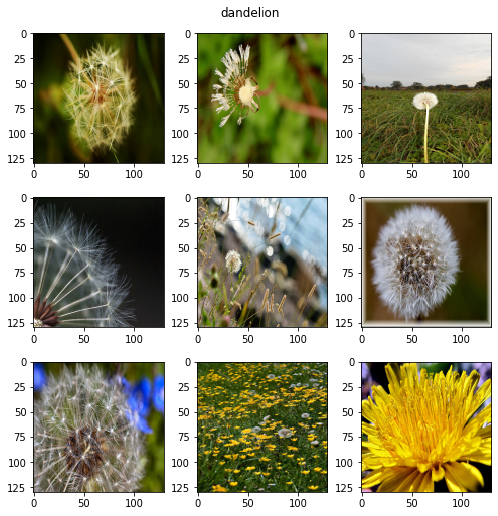

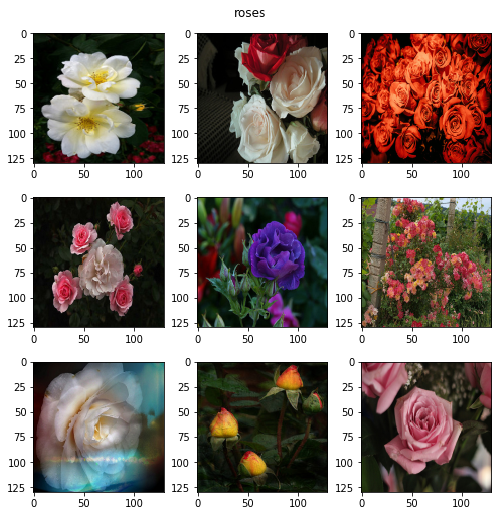

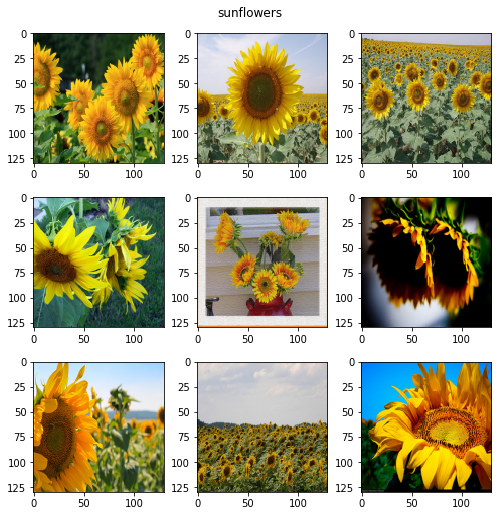

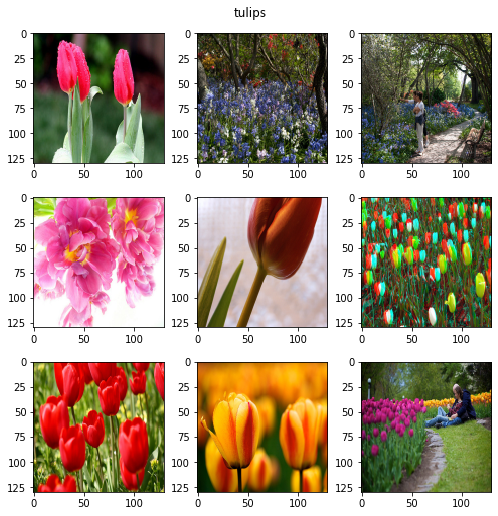

In [7]:
train_x_dat = []; valid_x_dat = []; test_x_dat = []
train_y_dat = []; valid_y_dat = []; test_y_dat = []

for flower_name in flower_list :
#     flower_name = flower_list[0]
    flower_dir = os.path.join(data_dir,flower_name)
    flower_png_list = os.listdir(flower_dir)
    
    # Train
    # cv2는 BRG이기 떄문에 cv2.cvtColor함수로 BRG -> RGB로 변경
    train_x_data_list = np.array([cv2.resize(cv2.cvtColor(cv2.imread(os.path.join(flower_dir,s)),cv2.COLOR_BGR2RGB), (130, 130), interpolation = cv2.INTER_AREA) for s in flower_png_list[0:400]])
    train_y_data_list = np.array([flower_name for s in range(train_x_data_list.shape[0])])
    train_x_dat.append(train_x_data_list)
    train_y_dat.append(train_y_data_list)
    
    
    # Valid
    # cv2는 BRG이기 떄문에 cv2.cvtColor함수로 BRG -> RGB로 변경
    valid_x_data_list = np.array([cv2.resize(cv2.cvtColor(cv2.imread(os.path.join(flower_dir,s)),cv2.COLOR_BGR2RGB), (130, 130), interpolation = cv2.INTER_AREA) for s in flower_png_list[400:500]])
    valid_y_data_list = np.array([flower_name for s in range(valid_x_data_list.shape[0])])
    valid_x_dat.append(valid_x_data_list)
    valid_y_dat.append(valid_y_data_list)
    
    # Test
    # cv2는 BRG이기 떄문에 cv2.cvtColor함수로 BRG -> RGB로 변경
    test_x_data_list = np.array([cv2.resize(cv2.cvtColor(cv2.imread(os.path.join(flower_dir,s)),cv2.COLOR_BGR2RGB), (130, 130), interpolation = cv2.INTER_AREA) for s in flower_png_list[500:600]])
    test_y_data_list = np.array([flower_name for s in range(test_x_data_list.shape[0])])
    test_x_dat.append(test_x_data_list)
    test_y_dat.append(test_y_data_list)
    
    
    # graph
    fig, ax = plt.subplots(3,3, figsize = (7,7))
#     ax = ax.ravel()
    for i in range(3):
        ax[0][i].imshow(train_x_data_list[i])
    for i in range(3):
        ax[1][i].imshow(valid_x_data_list[i])
    for i in range(3):
        ax[2][i].imshow(test_x_data_list[i])
        
    fig.tight_layout()    
    fig.suptitle(flower_name, y = 1.02) 

### 데이터 전처리

In [8]:
train_y_dat = np.array(train_y_dat).flatten()
valid_y_dat = np.array(valid_y_dat).flatten()
test_y_dat = np.array(test_y_dat).flatten()

In [9]:
train_onehot_y = np.array(pd.get_dummies(train_y_dat))
valid_onehot_y = np.array(pd.get_dummies(valid_y_dat))
test_onehot_y = np.array(pd.get_dummies(test_y_dat))

train_array_x = np.array(train_x_dat).reshape(len(train_y_dat),130,130,3)
valid_array_x = np.array(valid_x_dat).reshape(len(valid_y_dat),130,130,3)
test_array_x = np.array(test_x_dat).reshape(len(test_y_dat),130,130,3)

In [10]:
# Scale
train_array_x = train_array_x/255
valid_array_x = valid_array_x/255
test_array_x = test_array_x/255

### Cnn 모델링 - HB vs BO

       Tuning Method : Hyper Band       
Tuner Search Try - 00
INFO:tensorflow:Oracle triggered exit
{'initializer': 'random_normal', 'num_layers': 3, 'units_1': 32, 'dropout_1': False, 'dense_drop1': 0.1, 'dense1_units': 32, 'dense_drop2': 0.2, 'l2': 0.01016141691025321, 'lr': 0.0015929086245058178, 'conv1_drop': 0.1, 'units_2': 16, 'dropout_2': False, 'units_3': 32, 'dropout_3': False, 'conv2_drop': 0.2, 'conv3_drop': 0.2, 'tuner/epochs': 10, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 130, 130, 3)]     0         
                                                                 
 cnn_layer_1 (Conv2D)        (None, 130, 130, 32)      896       
                                                                 
 conv1_nor (BatchNormalizati  (None, 130, 130, 32)     128       
 on)    

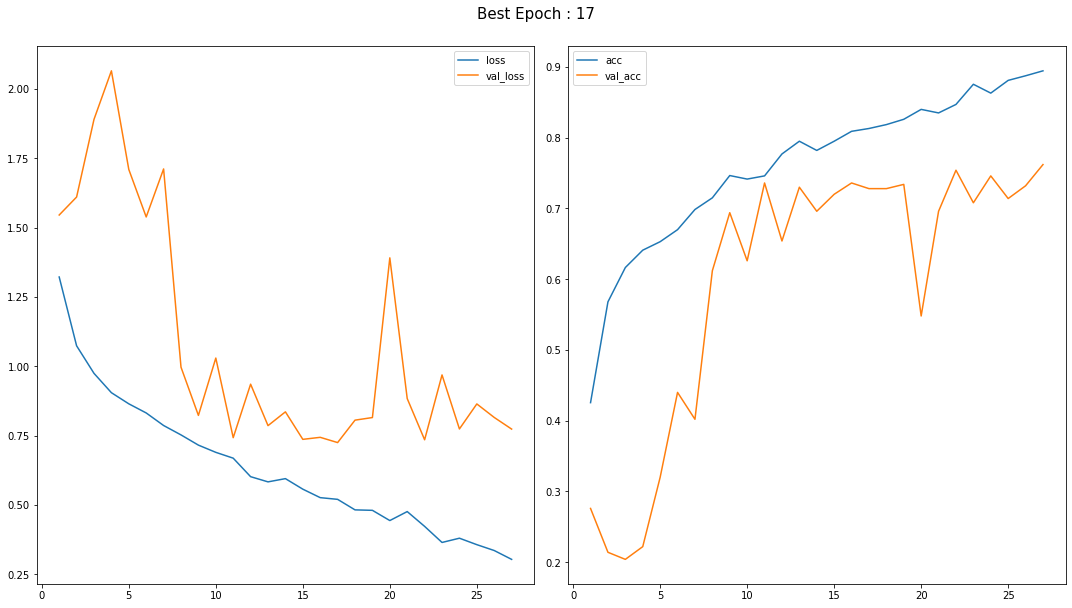

 Tuning Method : Bayesian Optimization  
Tuner Search Try - 00


In [ ]:
# 모델 저장 경로
hb_mdl_path = os.path.join(model_path,'cnn_model_hb.h5')
bo_mdl_path = os.path.join(model_path,'cnn_model_bo.h5')

# 모델 Fit
cnn_model_hb = mdl.MODELING_CNN(train_array_x,train_onehot_y,valid_array_x, valid_onehot_y, "HB")
cnn_model_bo = mdl.MODELING_CNN(train_array_x,train_onehot_y,valid_array_x, valid_onehot_y, "BO")

# 모델 저장
cnn_model_hb.model.save(hb_mdl_path)
cnn_model_bo.model.save(bo_mdl_path)